#### Cargar datos 

In [2]:
import pandas as pd

# Cargar el archivo
file_path = './data/orders_orders.xlsx'
data = pd.read_excel(file_path)

# Inspeccionar los datos para ver las columnas disponibles
print(data.head())

# Asegurarnos de que la columna de fechas está en formato datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Mostrar el rango de fechas
start_date = data['Order Date'].min()
end_date = data['Order Date'].max()

print(f"Los datos abarcan desde {start_date} hasta {end_date}.")


          Category           City   Country Customer ID    Customer Name  \
0  Office Supplies    Constantine   Algeria   TB-112801  Toby Braunhardt   
1  Office Supplies  Dar es Salaam  Tanzania    JG-51151       Jack Garza   
2  Office Supplies       Khartoum     Sudan    JC-53401  Jasper Cacioppo   
3  Office Supplies       Khartoum     Sudan    JC-53401  Jasper Cacioppo   
4       Technology         Luanda    Angola    GK-46201      Grace Kelly   

  Market Order Date      Order ID Order Priority        Product ID  ...  \
0   EMEA 2011-01-01  AG-2011-2040         Medium  OFF-TEN-10000025  ...   
1   EMEA 2011-01-03  TZ-2011-7370         Medium  OFF-STI-10000388  ...   
2   EMEA 2011-01-04  SU-2011-5190         Medium  OFF-BOS-10004950  ...   
3   EMEA 2011-01-04  SU-2011-5190         Medium  OFF-AVE-10003279  ...   
4   EMEA 2011-01-06  AO-2011-4910         Medium  TEC-LOG-10003079  ...   

   Ship Date       Ship Mode          State Sub-Category Discount  \
0 2011-01-06  Standard 

#### Mostramos el rango de fechas 

In [3]:
# Asegurarnos de que la columna 'Order Date' está en formato datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Mostrar el rango de fechas
start_date = data['Order Date'].min()
end_date = data['Order Date'].max()

print(f"Los datos abarcan desde {start_date} hasta {end_date}.")


Los datos abarcan desde 2011-01-01 00:00:00 hasta 2014-12-31 00:00:00.


Nos interesa ver los datos sumados a diario, porque cada linea de order date es un pedido pero queremos saber cuanto dinero se hace al dia.
Haremos el codigo necesario para toda la muestra de datos antes de separar train y test

In [4]:
# Sumar ventas diarias
daily_sales = data.groupby('Order Date')['Sales'].sum().reset_index()

# Separar datos en train (2011-2013) y test (2014)
train = daily_sales[daily_sales['Order Date'] < '2014-01-01']
test = daily_sales[(daily_sales['Order Date'] >= '2014-01-01') & (daily_sales['Order Date'] <= '2014-12-31')]

# Visualizar las primeras filas de cada conjunto
print("Train:\n", train.head())
print("\nTest:\n", test.head())


Train:
   Order Date       Sales
0 2011-01-01   808.56300
1 2011-01-02   314.22000
2 2011-01-03  4503.53720
3 2011-01-04  2808.87024
4 2011-01-05  3662.31000

Test:
      Order Date        Sales
1069 2014-01-01   3614.03450
1070 2014-01-02   4169.51614
1071 2014-01-03  11327.62200
1072 2014-01-04   4705.27370
1073 2014-01-05    426.66000


Se puede ver que la muestra ya está separada correctamente con los datos de 2011 hasta el 2013 para el train y un año entero de test (2014)

Ahora también tenemos que ver que los datos que generan extremos y pueden engañar el modelo a la hora de entrenarlo
Sobre todo viendo dias con sumatorios de ventas inferiores a 10 (umbral) y con fechas faltantes

In [5]:
# Crear un rango completo de fechas
date_range = pd.date_range(start=train['Order Date'].min(), end=train['Order Date'].max())

# Rellenar fechas faltantes con 0 en ventas
train = train.set_index('Order Date').reindex(date_range, fill_value=0).rename_axis('Order Date').reset_index()

# Aplicar un umbral para cifras bajas (por ejemplo, reemplazar ventas < 10 con el promedio)
threshold = 10
mean_sales = train.loc[train['Sales'] >= threshold, 'Sales'].mean()
train['Sales'] = train['Sales'].apply(lambda x: mean_sales if x < threshold else x)

print(train.head())


  Order Date       Sales
0 2011-01-01   808.56300
1 2011-01-02   314.22000
2 2011-01-03  4503.53720
3 2011-01-04  2808.87024
4 2011-01-05  3662.31000


Ahora propongo la visualización de los datos de train y los gráficos también papra qe se vea la tendencia, estacionalidad y residuo.

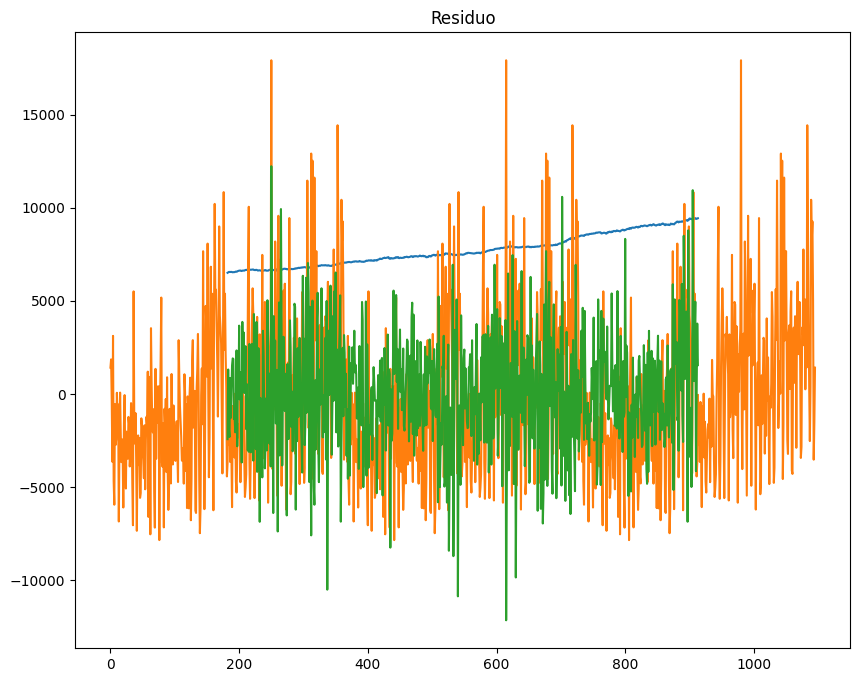

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de los datos
decompose_result = seasonal_decompose(train['Sales'], model='additive', period=365)

# Graficar los resultados de la descomposición
plt.figure(figsize=(10, 8))
decompose_result.trend.plot(title='Tendencia')
decompose_result.seasonal.plot(title='Estacionalidad')
decompose_result.resid.plot(title='Residuo')
plt.show()


Planteamos los gráficos separados para que se vean mejor

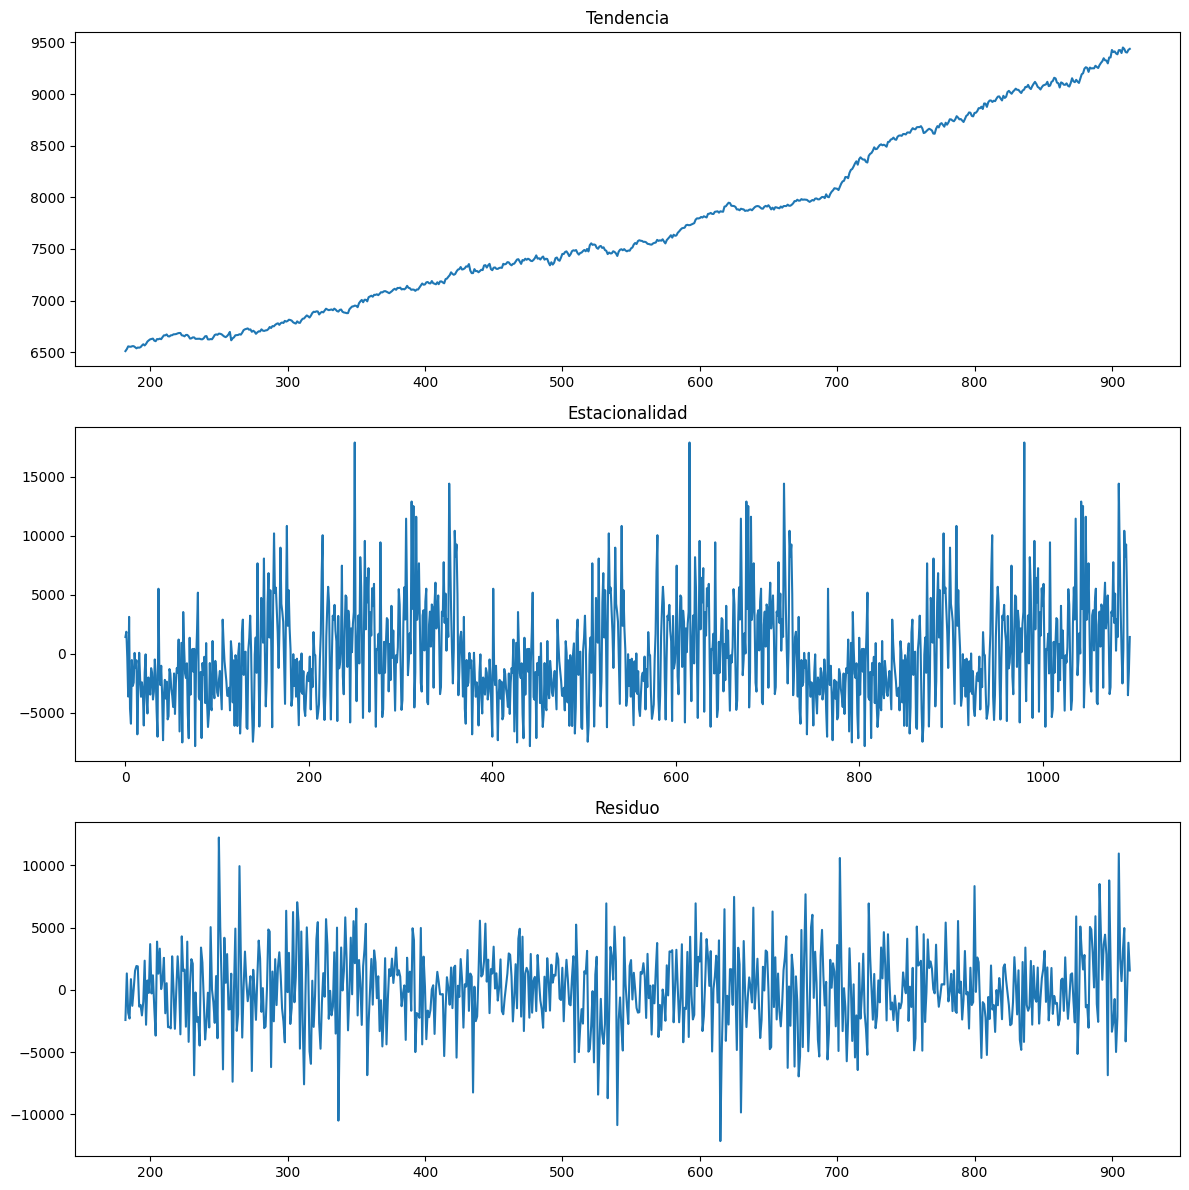

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de los datos
decompose_result = seasonal_decompose(train['Sales'], model='additive', period=365)

# Crear gráficos separados para cada componente
plt.figure(figsize=(12, 12))

# Gráfico de la tendencia
plt.subplot(3, 1, 1)
decompose_result.trend.plot()
plt.title('Tendencia')

# Gráfico de la estacionalidad
plt.subplot(3, 1, 2)
decompose_result.seasonal.plot()
plt.title('Estacionalidad')

# Gráfico de los residuos
plt.subplot(3, 1, 3)
decompose_result.resid.plot()
plt.title('Residuo')

plt.tight_layout()  # Ajustar el espaciado entre los gráficos
plt.show()


Para ver estacionalidad realizamos el test de adfuller con los datos de train

In [7]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller Aumentada
adf_test = adfuller(train['Sales'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"{key}: {value}")


ADF Statistic: -3.2199008816169927
p-value: 0.018861253178411513
Critical Values:
1%: -3.436459052172655
5%: -2.864237372528562
10%: -2.568206176974609



El resultado del test de ADF (Augmented Dickey-Fuller) que has proporcionado indica que la serie temporal es estacionaria. Esto se puede deducir porque:

El valor del ADF Statistic (-3.2199) es mayor (más negativo) que los valores críticos en el 1%, 5% y 10%, lo que sugiere que la hipótesis nula de que la serie es no estacionaria puede ser rechazada.
El p-value es de 0.018, lo que también está por debajo del umbral de 0.05, lo que indica que la serie temporal es estadísticamente significativa y se puede considerar como estacionaria.
Con esto en mente, el modelo que debería funcionar mejor es:
ARIMA(p, d, q) sin estacionalidad (SARIMA):

Dado que la serie es estacionaria (según el test ADF), no es necesario aplicar diferenciación estacional ni componentes estacionales.
Por lo tanto, un modelo ARIMA estándar debería ser adecuado, sin la necesidad de la parte estacional del SARIMA.

Entrenamos el modelo de ARIMA y SARIMA. De momento, planteamos los parámetros en 1,1,1 para luego si es necesario los modificaremos adaptando de verdad lo que necesita el modelo.

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Ajuste de un modelo ARIMA
arima_model = ARIMA(train['Sales'], order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Ajuste de un modelo SARIMA (identificar automáticamente los parámetros)
sarima_model = auto_arima(train['Sales'], seasonal=True, m=12, trace=True)
sarima_model.fit(train['Sales'])


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 1096
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10935.608
Date:                Mon, 18 Nov 2024   AIC                          21877.217
Time:                        21:10:49   BIC                          21892.212
Sample:                             0   HQIC                         21882.891
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0901      0.030      3.014      0.003       0.032       0.149
ma.L1         -0.9464      0.010    -98.070      0.000      -0.965      -0.927
sigma2      2.763e+07    1.2e-11    2.3e+18      0.0

ARIMA(order=(2, 1, 5), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

Planteamos la predicción del modelo entrenado con el train para el test

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicciones del modelo ARIMA
arima_forecast = arima_result.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test['Sales'], arima_forecast))
arima_mae = mean_absolute_error(test['Sales'], arima_forecast)

# Predicciones del modelo SARIMA
sarima_forecast = sarima_model.predict(n_periods=len(test))
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))
sarima_mae = mean_absolute_error(test['Sales'], sarima_forecast)

# Resultados
print(f"ARIMA - RMSE: {arima_rmse}, MAE: {arima_mae}")
print(f"SARIMA - RMSE: {sarima_rmse}, MAE: {sarima_mae}")


ARIMA - RMSE: 7736.2748428369105, MAE: 6444.526627700249
SARIMA - RMSE: 9776.02693169478, MAE: 8208.95909788409


In [13]:
from pmdarima import ARIMA as pmdARIMA
from pmdarima.model_selection import train_test_split

# Separar un subconjunto para validación cruzada
train_split, val_split = train_test_split(train['Sales'], train_size=0.8)

# GridSearch para ARIMA/SARIMA
grid_search_model = auto_arima(train_split, seasonal=True, m=12, 
                               stepwise=True, suppress_warnings=True, 
                               error_action="ignore", trace=True)

# Ver los mejores parámetros
print(grid_search_model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=17257.211, Time=4.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=17793.937, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=17593.267, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17275.105, Time=2.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=17791.938, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=17252.927, Time=3.10 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=17278.718, Time=1.49 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=17250.564, Time=7.83 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=9.22 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=17274.413, Time=3.03 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=17292.573, Time=2.44 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=17269.261, Time=2.90 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=17172.802, Time=11.38 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=17172.210, Time=4.31 sec
 ARIMA(2,1

Según el resultado de la búsqueda en GridSearch, el modelo ARIMA(2, 1, 5)(2, 0, 2)[12] parece ser el que mejor se ajusta según el AIC (Criterio de Información de Akaike). Este modelo se ajusta mejor a los datos, ya que tiene el valor de AIC más bajo, lo que sugiere que es el modelo más parsimonioso, es decir, el que explica los datos sin ser demasiado complejo.

Parámetros recomendados:

ARIMA(p, d, q): (2, 1, 5)
p = 2: Número de términos autorregresivos.
d = 1: Diferenciación de los datos para hacer la serie estacionaria.
q = 5: Número de términos de media móvil.
Estacionalidad (SARIMA):
(P, D, Q, s): (2, 0, 2, 12)
P = 2: Términos autorregresivos estacionales.
D = 0: Sin diferenciación estacional, ya que se considera que los datos no necesitan una diferencia estacional.
Q = 2: Términos de media móvil estacional.
s = 12: Periodo estacional (en este caso, se asume que es un modelo anual con 12 meses).
Estos parámetros pueden ser utilizados para entrenar el modelo de nuevo y obtener las predicciones más ajustadas.

In [16]:
# Calcular la cifra total real de ventas para cada año
real_sales_per_year = test.groupby(test['Order Date'].dt.year)['Sales'].sum()

# Mostrar el resultado con un formato adecuado
real_sales_per_year = real_sales_per_year.apply(lambda x: "{:,.0f}".format(x))  # Formato más legible

# Ver las cifras reales de ventas por cada año
print(real_sales_per_year)


Order Date
2014    4,299,866
Name: Sales, dtype: object


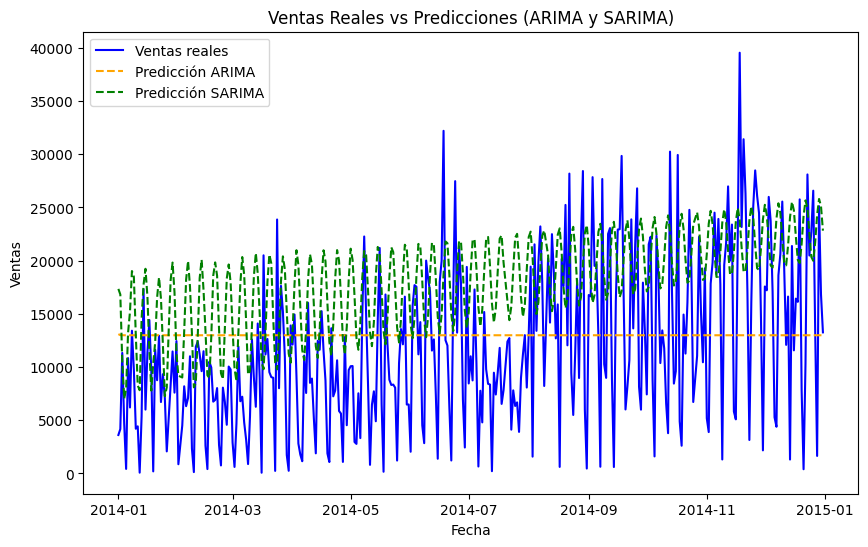

In [18]:
# Graficar las predicciones de ARIMA vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(test['Order Date'], test['Sales'], label='Ventas reales', color='blue')
plt.plot(test['Order Date'], arima_forecast, label='Predicción ARIMA', color='orange', linestyle='--')
plt.plot(test['Order Date'], sarima_forecast, label='Predicción SARIMA', color='green', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Reales vs Predicciones (ARIMA y SARIMA)')
plt.legend()
plt.show()


Ahora planteamos cuales serian las cifras de 2015 con el modelo ya entrenado

In [23]:
# Predicción de ventas para todo el año 2015 usando ARIMA
arima_forecast_2015 = arima_result.forecast(steps=365)  # 365 días para el año 2015


In [24]:
# Predicción de ventas para todo el año 2015 usando SARIMA
sarima_forecast_2015 = sarima_model.predict(start='2015-01-01', end='2015-12-31')


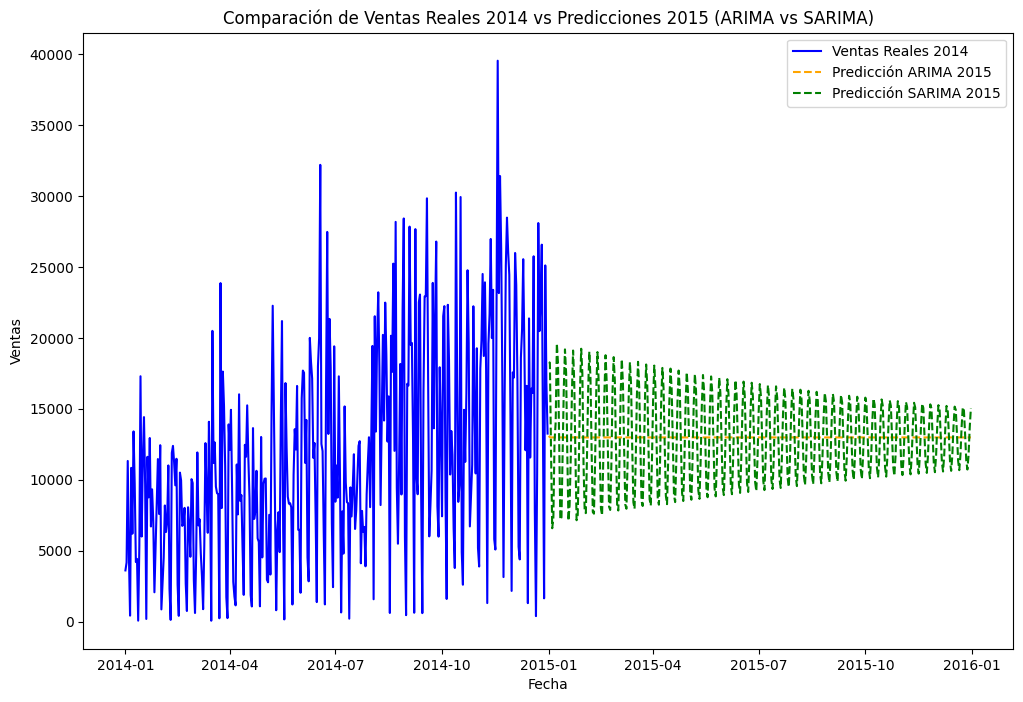

In [40]:
# Predicción de ventas para 2015 con SARIMA usando forecast
sarima_forecast_2015 = sarima_result.forecast(steps=365)

# Graficar las ventas reales de 2014 y las predicciones de 2015
plt.figure(figsize=(12, 8))

# Gráfico de ventas reales de 2014
plt.plot(real_sales_2014.index, real_sales_2014.values, label='Ventas Reales 2014', color='blue')

# Gráfico de predicción ARIMA para 2015
plt.plot(forecast_dates_2015, arima_forecast_2015, label='Predicción ARIMA 2015', color='orange', linestyle='--')

# Gráfico de predicción SARIMA para 2015
plt.plot(forecast_dates_2015, sarima_forecast_2015, label='Predicción SARIMA 2015', color='green', linestyle='--')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Comparación de Ventas Reales 2014 vs Predicciones 2015 (ARIMA vs SARIMA)')
plt.legend()

# Mostrar gráfico
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=21805.845, Time=7.80 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22479.926, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=22250.821, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=21856.942, Time=2.54 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22477.930, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=21806.824, Time=3.85 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=21812.813, Time=4.10 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=21811.570, Time=12.43 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=11.41 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=21836.072, Time=2.48 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=21801.527, Time=9.35 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=21847.438, Time=3.64 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=21869.059, Time=2.94 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=21836.791, Time=7.57 sec
 ARIMA(2,

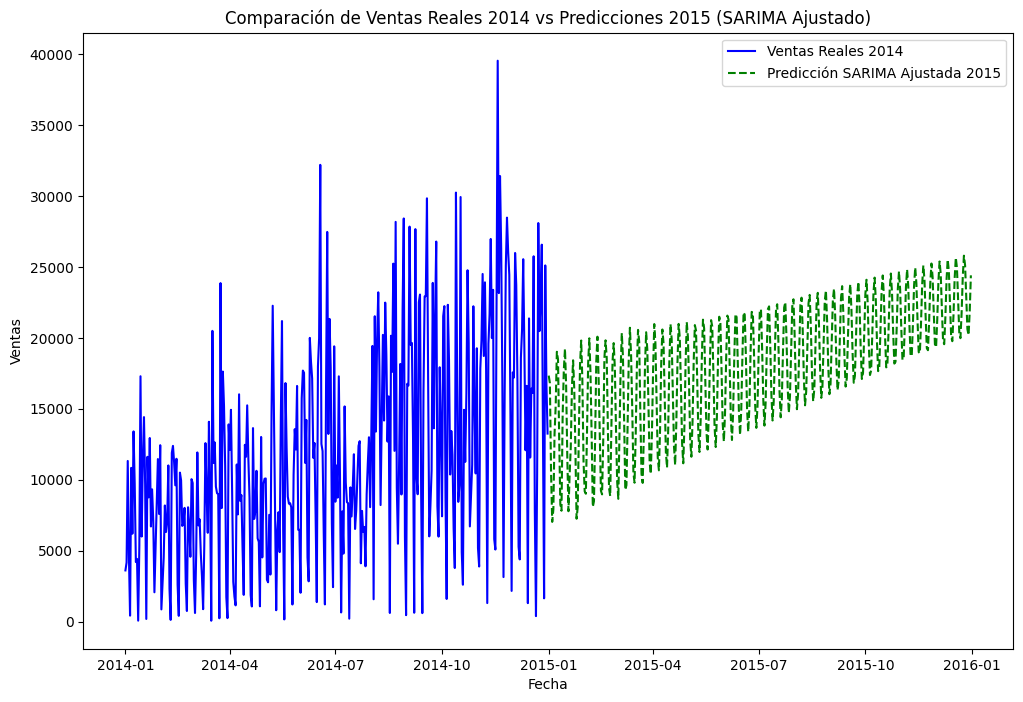

In [41]:
from pmdarima import auto_arima

# Ajuste automático de parámetros SARIMA
auto_model = auto_arima(train['Sales'], seasonal=True, m=12, stepwise=True, trace=True)

# Predicción para 2015
sarima_auto_forecast = auto_model.predict(n_periods=365)

# Graficar las ventas reales y las predicciones
plt.figure(figsize=(12, 8))
plt.plot(real_sales_2014.index, real_sales_2014.values, label='Ventas Reales 2014', color='blue')
plt.plot(forecast_dates_2015, sarima_auto_forecast, label='Predicción SARIMA Ajustada 2015', color='green', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Comparación de Ventas Reales 2014 vs Predicciones 2015 (SARIMA Ajustado)')
plt.legend()
plt.show()


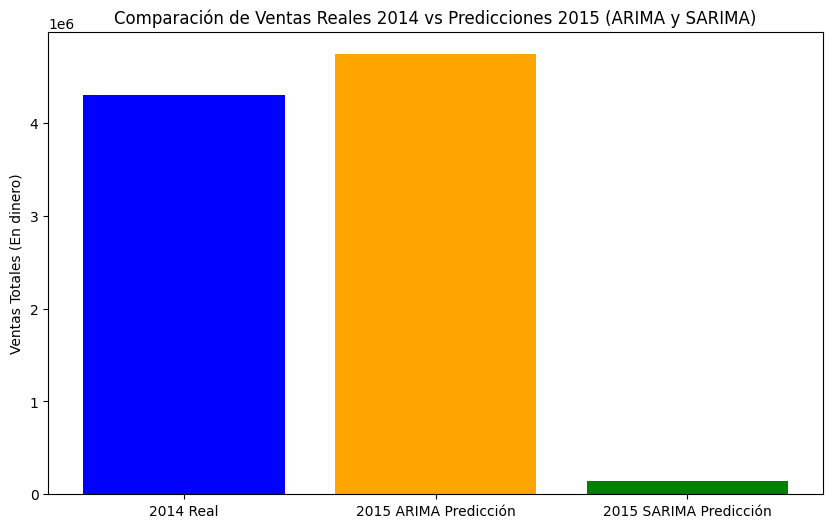

Ventas Reales 2014: 4299865.87056
Predicción ARIMA 2015: 4740454.974095453
Predicción SARIMA 2015: 138577.2827210289


In [29]:
# Sumar las ventas reales de 2014
real_sales_2014_total = real_sales_2014.sum()

# Sumar las predicciones de ventas para 2015 (usamos la predicción diaria de ARIMA y SARIMA y sumamos)
arima_sales_2015_total = np.sum(arima_forecast_2015)
sarima_sales_2015_total = np.sum(sarima_forecast_2015)

# Graficar las comparaciones anuales
plt.figure(figsize=(10, 6))

# Bar chart para comparar ventas reales 2014 vs predicciones 2015
years = ['2014 Real', '2015 ARIMA Predicción', '2015 SARIMA Predicción']
sales = [real_sales_2014_total, arima_sales_2015_total, sarima_sales_2015_total]

plt.bar(years, sales, color=['blue', 'orange', 'green'])

# Etiquetas y título
plt.ylabel('Ventas Totales (En dinero)')
plt.title('Comparación de Ventas Reales 2014 vs Predicciones 2015 (ARIMA y SARIMA)')

# Mostrar gráfico
plt.show()

# Imprimir los valores de ventas totales
print(f"Ventas Reales 2014: {real_sales_2014_total}")
print(f"Predicción ARIMA 2015: {arima_sales_2015_total}")
print(f"Predicción SARIMA 2015: {sarima_sales_2015_total}")


In [20]:
# Predicción de ventas para 2015 usando ARIMA
arima_forecast_2015 = arima_result.forecast(steps=365)

# Sumar las predicciones diarias para obtener el total de ventas de 2015
arima_total_2015 = np.sum(arima_forecast_2015)

# Mostrar la predicción total de ventas para 2015
print(f"Predicción total de ventas para 2015 (ARIMA): {arima_total_2015:,.0f}")


Predicción total de ventas para 2015 (ARIMA): 4,740,455


In [21]:
# Predicción de ventas para 2015 usando SARIMA
sarima_forecast_2015 = sarima_model.predict(start='2015-01-01', end='2015-12-31')

# Sumar las predicciones diarias para obtener el total de ventas de 2015
sarima_total_2015 = np.sum(sarima_forecast_2015)

# Mostrar la predicción total de ventas para 2015
print(f"Predicción total de ventas para 2015 (SARIMA): {sarima_total_2015:,.0f}")


Predicción total de ventas para 2015 (SARIMA): 138,577


Volvemos a entrenar el modelo con los mejores resultados del gridsearch teniendo en cuenta que además no tiene estacionariedad los datos

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenar el modelo SARIMA con los mejores parámetros encontrados
sarima_model = SARIMAX(train['Sales'], order=(2, 1, 5), seasonal_order=(2, 0, 2, 12))
sarima_result = sarima_model.fit()

# Predicciones
sarima_forecast = sarima_result.predict(start=test.index[0], end=test.index[-1])

# Mostrar los resultados
print(sarima_result.summary())


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                   Sales   No. Observations:                 1096
Model:             SARIMAX(2, 1, 5)x(2, 0, [1, 2], 12)   Log Likelihood              -10813.768
Date:                                 Mon, 18 Nov 2024   AIC                          21651.537
Time:                                         22:55:06   BIC                          21711.519
Sample:                                              0   HQIC                         21674.233
                                                - 1096                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2446      0.005    258.208      0.000       1.235       1

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calcular RMSE
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))

# Calcular MAE
sarima_mae = mean_absolute_error(test['Sales'], sarima_forecast)

# Mostrar los resultados
print(f"SARIMA - RMSE: {sarima_rmse}, MAE: {sarima_mae}")


SARIMA - RMSE: 7977.557842562645, MAE: 6717.7790721771125
